In [1]:
import pandas as pd
import numpy as np
import re
import googletrans
from googletrans import Translator
from langdetect import detect
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import csv
import datetime
from tqdm import tqdm
from tqdm.notebook import tqdm_notebook
from sklearn.preprocessing import MinMaxScaler

#import multiprocessing
#from pyspark.sql.functions import udf
#from pyspark.sql.types import StringType
#from pyspark.sql import SparkSession
#pd.set_option('display.max_rows', None)

In [26]:
import os
import openpyxl

def is_excel_file(filename):
    _, extension = os.path.splitext(filename)
    return extension.lower() == '.xlsm'

def check_excel_columns(file_path, required_columns):
    wb = openpyxl.load_workbook(file_path)
    sheet = wb.active
    header_row = sheet[1]
    column_names = [cell.value for cell in header_row]
    missing_columns = [col for col in required_columns if col not in column_names]
    
    return missing_columns

def test_files():
    required_columns = [
        "Program", "Year", "Term", "Status", "Program Date Record: Start Date",
        "Program Date Record: End Date", "Program Currently Assigned City",
        "Program Currently Assigned Country", "Program Type", "Student ID",
        "Country of Citizenship", "Degree Program 1","Degree Program 2",
        "Points Completed - Total", "Weighted Average", "Postgraduate flag"
    ]
     
    user_input = input("Please Enter the file name (press Return to submit): ")

    files = ['GL Data 2019-2020.xlsm', 'GL Data 2021-23.xlsm', 'GL Data pre 2019.xlsm', '2023 Data.xlsm']
    
    if user_input != '': 
        files.append(user_input)
   
    for file in files:
        if is_excel_file(file):
            missing_columns = check_excel_columns(file, required_columns)
            if missing_columns:
                print(f"{file}: The Excel missing the follow columns:")
                for col in missing_columns:
                    print(f"- {col}")
            else:
                print(f"{file}: Good Excel")
        else:
            print(f"{file}: Excel ONLY !!!")

        


In [27]:
if __name__ == "__main__":
    # test files
    test_files()
    print('---------------------------------')
    processed_data_list = []
    files = ['GL Data 2019-2020.xlsm','GL Data 2021-23.xlsm','GL Data pre 2019.xlsm','2023 Data.xlsm']
    required_columns = [
        "Program", "Year", "Term", "Status", "Program Date Record: Start Date",
        "Program Date Record: End Date", "Program Currently Assigned City",
        "Program Currently Assigned Country", "Program Type", "Student ID",
        "Country of Citizenship", "Degree Program 1","Degree Program 2",
        "Points Completed - Total", "Weighted Average", "Postgraduate flag"
    ]
    processed_data_list = []
    for file in files:
        data = pd.read_excel(file)
        data = data[required_columns]
        processed_data_list.append(data)

    whole_data = pd.concat(processed_data_list)
    whole_data.head()
    whole_data.to_csv('total_data.csv', index=False)
    print(" File 'total_data.csv' all good to go :) ")

Please Enter the file name (press Return to submit): 
GL Data 2019-2020.xlsm: Good Excel
GL Data 2021-23.xlsm: Good Excel
GL Data pre 2019.xlsm: Good Excel
2023 Data.xlsm: Good Excel
---------------------------------
 File 'total_data.csv' all good to go :) 


In [44]:
data = pd.read_csv('total_data.csv')

/Users/shenggangqian/opt/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [45]:
column_data = data['Term']
data = data[column_data != "NCP"]
data['Program Date Record: End Date']  =data['Program Date Record: End Date'].fillna(0)
data['Program Date Record: Start Date']  =data['Program Date Record: Start Date'].fillna(0)

data['Program Date Record: End Date'] = pd.to_datetime(data['Program Date Record: End Date'])
data['Program Date Record: Start Date'] = pd.to_datetime(data['Program Date Record: Start Date'])
data['Days'] = (data['Program Date Record: End Date'] - data['Program Date Record: Start Date']).dt.days

avg_days = {}


for term in data['Term'].unique():
    filtered_df = data[(data['Term'] == term) & (data['Days'] > 0)]
    avg_days[term] = filtered_df['Days'].mean()

    

for term in data['Term'].unique():
    data.loc[(data['Term'] == term) & (data['Days'] <= 0), 'Days'] = avg_days[term]

data['Days'] = np.round(data['Days']) 



# Are there program with 0 days?
#stanardize the name of citizenships

data['Country of Citizenship']  = data['Country of Citizenship'] .replace({'Country not known': 'NaN',
                                                                       'Not entered': 'NaN','Laos': "Lao People's Democratic Republic",
                                                                      'Republic of Korea': 'Korea, Republic of (South)',
                                                                      'Hong Kong':'Hong Kong (SAR of China)'})

#assign the status to three types.
success_substrings = ["Accepted", "Approved", "Nominated", "Finalised", "Committed"]
unsuccessful_substrings = ["Withdrawn", "Unsuccessful", "Cancelled","Deceased","Reserved","Exemption Requested"]
pending_substring = ["Pending","Awaiting","Waitlist","Extension"]


data["Status"] = np.where(data["Status"].str.contains('|'.join(success_substrings)), "Successful", 
                        np.where(data["Status"].str.contains('|'.join(unsuccessful_substrings)), "Unsuccessful", data["Status"]))


data["Status"] = np.where(data["Status"].str.contains('|'.join(pending_substring)), "Pending", data["Status"])


today = datetime.date.today()


for index, row in data.iterrows():
    if any(substring in row['Status'] for substring in pending_substring):
        end_date = pd.to_datetime(row['Program Date Record: End Date'])
        if end_date <= today:
            data.at[index, 'Status'] = "Successful"
            



/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/809285832.py:53: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if end_date <= today:


In [46]:
# data consistency

#data['School of Enrolment'].replace('Veterinary & Agricultural Sciences', 'Veterinary and Agricultural Sciences', inplace=True)
#data['School of Enrolment'].replace('Engineering', 'Engineering and IT', inplace=True)
#data[~data['School of Enrolment'].astype(str).str.contains(re.compile(r'\d'))]

data['Student ID'] = data['Student ID'].fillna(0).astype(int)
data['Weighted Average'] = data['Weighted Average'].apply(lambda x: re.sub(r'[^\d\.]+', '', str(x)))
data['Weighted Average'] = pd.to_numeric(data['Weighted Average'], errors='coerce')
data= data.dropna(subset=['Weighted Average', 'Degree Program 1', 'Degree Program 2','Country of Citizenship'], how='all')  
data['Postgraduate flag'].replace('False','N',inplace=True)
data['Postgraduate flag'].replace('True','Y',inplace=True)
data['Postgraduate flag'].replace('Yes','Y',inplace=True)
data['Weighted Average'].replace(0, np.nan, inplace=True)
data['Degree Program 1'].fillna(data['Degree Program 2'], inplace=True)
data['Degree Program 1'] = data['Degree Program 1'].astype(str)
data = data.drop(['Degree Program 2'],axis = 1)



In [47]:
# postgraduate flag consistency
master_pattern = re.compile(r'\bMaster\b', re.IGNORECASE)
bachelor_pattern = re.compile(r'\bBachelor\b', re.IGNORECASE)
postgrad_pattern = re.compile(r'\bPostgraduate\b', re.IGNORECASE)
grad_pattern = re.compile(r'\bgraduate\b', re.IGNORECASE)
def update_postgrad_flag(row):
    
    if postgrad_pattern.search(row['Degree Program 1']):
        row['Postgraduate flag'] = 'Y'
    elif master_pattern.search(row['Degree Program 1']):
        row['Postgraduate flag'] = 'Y'
    elif bachelor_pattern.search(row['Degree Program 1']):
        row['Postgraduate flag'] = 'N'
    elif grad_pattern.search(row['Degree Program 1']):
        row['Postgraduate flag'] = 'N'    
    return row


data = data.apply(update_postgrad_flag, axis=1)


In [48]:
# weight mean into 4 different options
remove_n= data.dropna(subset=['Weighted Average'])
result_year = remove_n.groupby(['Postgraduate flag','Year','Degree Program 1'])['Weighted Average'].mean()
result_noneYear =  remove_n.groupby(['Postgraduate flag','Degree Program 1'])['Weighted Average'].mean()
result_OnlyFac =  remove_n.groupby(['Degree Program 1'])['Weighted Average'].mean()
normal_mean = remove_n['Weighted Average'].mean()
#means_year = result_year.to_dict()
means_noneYear = result_noneYear.to_dict()
means_OnlyFac = result_OnlyFac.to_dict()

In [49]:
# add average WAM in missing value in three options
for index, row in data[data['Weighted Average'].isnull()].iterrows():
    flag = row['Postgraduate flag']
    weighted_average = row['Weighted Average']
    points_completed_total = row['Points Completed - Total']

    if flag == 'Y' and (pd.isnull(weighted_average) or weighted_average == 0) and points_completed_total == 0:
        data.at[index, 'Weighted Average'] = 0  #  if flag is 'Y', weighted_average is NaN or 0, and points_completed_total is 0

    year = row['Year']
    school = row['Degree Program 1']


    if (flag, school) in means_noneYear:
        mean = means_noneYear[(flag, school)]
    elif school in means_OnlyFac:
        mean = means_OnlyFac[school]
    else:
        mean = normal_mean  # in this file is 73.75
        
    data.at[index, 'Weighted Average'] = mean



In [50]:
# wold rank
uni_rank = pd.read_csv('QS2023.csv')

In [51]:
rank_table = uni_rank[['institution', 'Rank']]

# add rank range in rank table
def get_rank_range(rank):
    if rank <= 10:
        return '1-10'
    elif rank <= 30:
        return '11-30'
    elif rank <= 50:
        return '31-50'
    elif rank <= 100:
        return '51-100'
    elif rank <= 250:
        return '101-250'
    elif rank <= 500:
        return '251-500'
    elif rank <= 1000:
        return '501-1000'
    else:
        return '1001-2000'
        

rank_table['rank_range'] = rank_table['Rank'].apply(get_rank_range)

/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/3747648403.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_table['rank_range'] = rank_table['Rank'].apply(get_rank_range)


In [56]:
tqdm.pandas() 
translator = Translator()

def translate(text):  
    return translator.translate(text, dest='en').text

def remove_brackets(name):
    name = re.sub(r'\([^()]*\)', '', name)  # remove parentheses and contents
    name = re.sub(r'\s*-\s+.+', '', name)  # remove everything after "-"
    return name.strip()

# change word to english format and delete and in abbreviation in '()'    
rank_table['University'] = rank_table['institution'].progress_apply(lambda x: translate(x) if not detect(x) == 'en' else x)
rank_table['University'] = rank_table['University'].progress_apply(remove_brackets)

 

100%|███████████████████████████████████████| 1418/1418 [02:32<00:00,  9.31it/s]
/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/4239923036.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_table['University'] = rank_table['institution'].progress_apply(lambda x: translate(x) if not detect(x) == 'en' else x)
100%|███████████████████████████████████| 1418/1418 [00:00<00:00, 131967.76it/s]
/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/4239923036.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [57]:
# letter learnning for data and rank table
rank_table['University'] = rank_table['University'].apply(lambda x: re.sub(r',.*', '', x).strip())
rank_table['University'] = rank_table['University'].apply(lambda x: re.sub(r'^[tT]he\s', '', x))
rank_table['University'] = rank_table['University'].apply(lambda x: re.sub(r',', '', x))
data['Program'] = data['Program'].apply(lambda x: re.sub(r',', '', x))

/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/4253600467.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_table['University'] = rank_table['University'].apply(lambda x: re.sub(r',.*', '', x).strip())
/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_34091/4253600467.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rank_table['University'] = rank_table['University'].apply(lambda x: re.sub(r'^[tT]he\s', '', x))
/var/folders/1z/4bpkvqs92875xgpvwhsf_wnw0000gn/T/ipykernel_3

In [58]:
# vectorized
university_regex = fr"\b({'|'.join(rank_table['University'].apply(re.escape))})\b"

data['University'] = data['Program'].str.extract(university_regex, flags=re.IGNORECASE, expand=False).fillna('unknown')


In [46]:
data

,Program,Year,Term,Status,Program Date Record: Start Date,Program Date Record: End Date,Program Currently Assigned City,Program Currently Assigned Country,Program Type,Student ID,Country of Citizenship,Degree Program 1,Points Completed - Total,Weighted Average,Postgraduate flag,Days,University
1,School of Chemistry Summer Research Project Ge...,2019,December,Successful,1970-01-01,1970-01-01,Berlin,Germany,"Research, Short-term overseas study-exchange",831957,Australia,Bachelor of Science,262.5,81.476,N,77.0,unknown
2,School of Chemistry Summer Research Project Ge...,2019,December,Successful,1970-01-01,1970-01-01,Berlin,Germany,"Research, Short-term overseas study-exchange",833570,Australia,Bachelor of Science,250.0,75.450,N,77.0,unknown
3,School of Chemistry Summer Research Project Ge...,2019,December,Successful,1970-01-01,1970-01-01,Berlin,Germany,"Research, Short-term overseas study-exchange",904849,China (excludes SARs and Taiwan),Bachelor of Science,250.0,72.450,N,77.0,unknown
5,Fudan University Chinese In-Country Intensive ...,2019,January,Successful,2018-12-27,2019-01-25,Shanghai,China,Short-term overseas study-fee paying,980297,Singapore,Bachelor of Arts,100.0,69.125,N,29.0,Fudan University
6,Fudan University Chinese In-Country Intensive ...,2019,January,Successful,2018-12-27,2019-01-25,Shanghai,China,Short-term overseas study-fee paying,640056,Australia,Master of Engineering,100.0,75.375,Y,29.0,Fudan University
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41623,*[IN-PERSON] [Fee-paying]AA Visiting School - ...,2023,Winter (June-July),Successful,1970-01-01,1970-01-01,London,United Kingdom,Short-term overseas study-fee paying,1270633,Australia,Bachelor of Science,250.0,78.440,N,27.0,unknown
41624,*[IN-PERSON] [Fee-paying] AA Visiting School -...,2023,Winter (June-July),Successful,1970-01-01,1970-01-01,London,United Kingdom,Short-term overseas study-fee paying,1263296,Australia,Bachelor of Design,225.0,70.500,N,27.0,unknown
41625,Cultural Tourism in Southeast Asia ANTH30017,2023,Winter (June-July),Unsuccessful,1970-01-01,1970-01-01,Bali,Indonesia,UMOS,1307200,Australia,Bachelor of Arts,200.0,74.670,N,27.0,unknown
41626,[IN-PERSON] [Fee-paying] In-Country Italian St...,2023,Winter (June-July),Successful,1970-01-01,1970-01-01,Multiple Locations,Italy,Short-term overseas study-fee paying,1269620,Australia,Bachelor of Biomedicine,250.0,79.870,N,27.0,unknown


In [12]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#university_set = set(rank_table['University'])

#def extract_university_name(program):
    #for university in university_set:
        #if re.search(fr"\b({re.escape(university)})\b", program):
            #return university
    #return 'unknown'

#extract_university_name_udf = udf(extract_university_name, StringType())

#spark_data = spark.createDataFrame(data)
#spark_data = spark_data.withColumn('University', extract_university_name_udf(spark_data['Program']))
#data = spark_data.toPandas()


In [59]:
withRankTable = pd.merge(data,rank_table,on = 'University',how = 'left')
withRankTable['Rank'] = withRankTable['Rank'].fillna(0).astype(int)
withRankTable['rank_range'] = withRankTable['rank_range'].fillna('Unknow')
#withRankTable['rank_range'].replace('1000','1000+',inplace=True)
withRankTable['Year'] = pd.to_datetime(data['Year'],format= '%Y')
withRankTable['Program Date Record: Start Date'] = pd.to_datetime(data['Program Date Record: Start Date'],format= '%Y')
withRankTable['Program Date Record: End Date'] = pd.to_datetime(data['Program Date Record: End Date'],format= '%Y')

In [2]:
rank_table.to_csv('after2023QS.csv', index=False)
withRankTable.to_csv('afterprocess.csv', index=False)

NameError: name 'rank_table' is not defined

In [86]:
afterdata = pd.read_csv('afterprocess.csv')
afterdata.columns
cordata = afterdata

In [87]:
#dummy


cat_vars = ['Program Type','Country of Citizenship','Program','Program Currently Assigned Country',
       'University','Term']

OneHot = OneHotEncoder(sparse=False)
encoded_vars = OneHot.fit_transform(cordata[cat_vars])

encoded_df = pd.DataFrame(encoded_vars, columns=OneHot.get_feature_names_out(cat_vars))
cordata.drop(cat_vars, axis=1, inplace=True)
cordata = pd.concat([afterdata, encoded_df], axis=1)
cordata = cordata.drop(['Student ID','Degree Program 1','institution','Rank','Year','Program Date Record: Start Date',
                        'Program Date Record: End Date','Year','Program Currently Assigned City'], axis = 1)
cordata

/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Status,Points Completed - Total,Weighted Average,Postgraduate flag,Days,rank_range,Program Type_Exchange,"Program Type_Exchange, Research","Program Type_Exchange, Study Abroad",Program Type_Fee-paying,...,Term_Semester 1,Term_Semester 2,Term_Semester 2 UMOS,Term_Summer,Term_Summer (Nov-Feb),Term_UMOS Summer Nov-Feb,Term_UMOS Winter Jun-July,Term_Winter,Term_Winter (June-July),Term_Winter Internship
0,Successful,262.5,81.476,N,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Successful,250.0,75.450,N,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Successful,250.0,72.450,N,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Successful,100.0,69.125,N,29.0,31-50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Successful,100.0,75.375,Y,29.0,31-50,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40080,Successful,250.0,78.440,N,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40081,Successful,225.0,70.500,N,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40082,Unsuccessful,200.0,74.670,N,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40083,Successful,250.0,79.870,N,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [88]:

rank_range_map = {
    '1-10': 1,
    '11-30': 2,
    '31-50': 3,
    '51-100': 4,
    '101-250': 5,
    '251-500': 6,
    '501-1000': 7,
    '1001-2000': 8,
}


flag_map = {
    'Y': 1,
    'N': 0,    
}


status = {
    'Successful' :1,
    'Unsuccessful' :0,
    
}

cordata['rank_range'] = cordata['rank_range'].replace(rank_range_map)
cordata['Postgraduate flag'] = cordata['Postgraduate flag'].replace(flag_map)
cordata = cordata[cordata['Status'] != 'Pending']

cordata.loc[:,'Status'] = cordata['Status'].replace(status)
model_data = cordata

In [89]:
model_data

,Status,Points Completed - Total,Weighted Average,Postgraduate flag,Days,rank_range,Program Type_Exchange,"Program Type_Exchange, Research","Program Type_Exchange, Study Abroad",Program Type_Fee-paying,...,Term_Semester 1,Term_Semester 2,Term_Semester 2 UMOS,Term_Summer,Term_Summer (Nov-Feb),Term_UMOS Summer Nov-Feb,Term_UMOS Winter Jun-July,Term_Winter,Term_Winter (June-July),Term_Winter Internship
0,1,262.5,81.476,0.0,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,250.0,75.450,0.0,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,250.0,72.450,0.0,77.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,100.0,69.125,0.0,29.0,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,100.0,75.375,1.0,29.0,3,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40080,1,250.0,78.440,0.0,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40081,1,225.0,70.500,0.0,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40082,0,200.0,74.670,0.0,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
40083,1,250.0,79.870,0.0,27.0,Unknow,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [50]:
label_vars = ['Term','Status']
for i in range(len(label_vars)):
    label = LabelEncoder().fit(afterdata[label_vars[i]])
    cordata[label_vars[i]] = label.transform(cordata[label_vars[i]])

KeyError: 'Term'

## Statistic Analysis

In [29]:
import pandas as pd
from scipy.stats import chi2_contingency

def perform_chi2_test(data):
    results = {}
    
    for column in data.columns:
        contingency_table = pd.crosstab(data[column], data[column].index)
        chi2_stat, p_value, _, _ = chi2_contingency(contingency_table)
        results[column] = {'Chi-square statistic': chi2_stat, 'P-value': p_value}
    
    return results

chi2_results = perform_chi2_test(detaili_data)

for variable, result in chi2_results.items():
    print(f"Variable: {variable}")
    print(result)
    print()


ValueError: No data; `observed` has size 0.

In [ ]:
detail_correlation_matrix = detaili_data.corr()
detail_correlation_matrix

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(detail_correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('corr.png')
plt.show()

#   Model

## data processing

In [10]:
import pandas as pd
from gensim.models import Word2Vec


# Load the data
model_data = pd.read_csv('afterprocess.csv')
cat_vars = ['Program Type','Country of Citizenship','Program Currently Assigned Country']
# Convert your categorical columns to list of lists for Word2Vec training
sentences = model_data[cat_vars].astype(str).values.tolist()

# Train a Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=50, window=2, min_count=1, workers=4)
w2v_model.save("word2vec.model")

# Convert your categorical columns to their vector representation

def convert_to_vector(word):
    try:
        return w2v_model.wv[word]
    except:
        return np.zeros(w2v_model.vector_size)

for var in cat_vars:
    vectors = model_data[var].astype(str).apply(convert_to_vector)
    vector_columns = [f"{var}_w2v_dim_{i}" for i in range(w2v_model.vector_size)]
    model_data[vector_columns] = pd.DataFrame(vectors.tolist(), index=model_data.index)

# Drop the original cat_vars columns
model_data.drop(cat_vars, axis=1, inplace=True)


rank_range_map = {
    'Unknow' :0,
    '1-10': 1,
    '11-30': 2,
    '31-50': 3,
    '51-100': 4,
    '101-250': 5,
    '251-500': 6,
    '501-1000': 7,
    '1001-2000': 8,
}


flag_map = {
    'Y': 1,
    'N': 0,    
}

state_map = {
    'Successful' : 1,
    'Unsuccessful': 0,
}


model_data['rank_range'] = model_data['rank_range'].replace(rank_range_map)
model_data['Postgraduate flag'] = model_data['Postgraduate flag'].replace(flag_map)
model_data =  model_data[model_data['Status'] != 'Pending']
model_data['Status'] = model_data['Status'].replace(state_map)

/tmp/ipykernel_801/3990485843.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_data[vector_columns] = pd.DataFrame(vectors.tolist(), index=model_data.index)
/tmp/ipykernel_801/3990485843.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  model_data[vector_columns] = pd.DataFrame(vectors.tolist(), index=model_data.index)
/tmp/ipykernel_801/3990485843.py:26: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining

In [22]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder


data = model_data.drop(['Program','Term','Student ID','institution','Program Date Record: End Date','Degree Program 1',
      'Points Completed - Total','Program','Year','Program Currently Assigned City','University','Program Date Record: Start Date'], axis = 1)     


data = data.dropna(subset=['Postgraduate flag','Days'])
data = data.to_numpy()
#data[data.isnull().any(axis = 1)]

KeyError: "['Program', 'Term', 'Program', 'Program Currently Assigned City', 'University'] not found in axis"

## logistic regression

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = data[:,1:]
y = data[:,0] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

model = LogisticRegression()

model.fit(X_train, y_train)


predictions = model.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 0.6142980189491818


/root/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## random Forest tree

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


X = data[:,1:]
y = data[:,0] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)


Accuracy: 0.7027131782945737
Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.70      0.71      4001
         1.0       0.69      0.70      0.69      3739

    accuracy                           0.70      7740
   macro avg       0.70      0.70      0.70      7740
weighted avg       0.70      0.70      0.70      7740



## SVM

In [ ]:
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np


X = data[:,1:]
y = data[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_rbf.fit(X_train, y_train)

y_pred = svr_rbf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")



## XGBOOST

In [29]:
#dummy

afterdata = pd.read_csv('afterprocess.csv')
afterdata.columns
cordata = afterdata

cat_vars = ['Program Type','Country of Citizenship','Program Currently Assigned Country',
       'University','Term']

OneHot = OneHotEncoder(sparse=False)
encoded_vars = OneHot.fit_transform(cordata[cat_vars])

encoded_df = pd.DataFrame(encoded_vars, columns=OneHot.get_feature_names_out(cat_vars))
cordata.drop(cat_vars, axis=1, inplace=True)
cordata = pd.concat([afterdata, encoded_df], axis=1)
cordata = cordata.drop(['Student ID','Degree Program 1','Program','institution','Rank','Year','Program Date Record: Start Date',
                        'Program Date Record: End Date','Year','University','Program Currently Assigned City'], axis = 1)


rank_range_map = {
    'Unknow' : 9,
    '1-10': 1,
    '11-30': 2,
    '31-50': 3,
    '51-100': 4,
    '101-250': 5,
    '251-500': 6,
    '501-1000': 7,
    '1001-2000': 8,
}


flag_map = {
    'Y': 1,
    'N': 0,    
}


status = {
    'Successful' :1,
    'Unsuccessful' :0,
    
}

cordata['rank_range'] = cordata['rank_range'].replace(rank_range_map)
cordata['Postgraduate flag'] = cordata['Postgraduate flag'].replace(flag_map)
cordata = cordata[cordata['Status'] != 'Pending']

cordata.loc[:,'Status'] = cordata['Status'].replace(status)
model_data = cordata


/root/miniconda3/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
data = model_data.dropna(subset=['Postgraduate flag','Days'])
data["Points Completed - Total"] = data["Points Completed - Total"].fillna(0)
data = data.to_numpy()


/tmp/ipykernel_4261/2121470869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Points Completed - Total"] = data["Points Completed - Total"].fillna(0)


In [4]:
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import optuna

X = data[:,1:]
y = data[:, 0]
y = y.astype(int)

# Splitting the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'n_estimators': trial.suggest_int('n_estimators', 50, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 15),
        'gamma': trial.suggest_float('gamma', 0.05, 1),
        'subsample': trial.suggest_float('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1, 5),
        'alpha': 1,
        'n_jobs': -1 
        
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test, ntree_limit=model.best_ntree_limit)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=80)

best_params = study.best_params

best_model = XGBClassifier(**best_params)
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")
print(f"Best Parameters: {best_params}")


[I 2023-09-21 13:07:58,147] A new study created in memory with name: no-name-ba26b8c7-3c0e-4a52-8f5e-340c4dfec797
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-21 13:08:18,970] Trial 0 finished with value: 0.7391793845384038 and parameters: {'learning_rate': 0.07746931842532452, 'n_estimators': 145, 'max_depth': 15, 'min_child_weight': 12, 'gamma': 0.09538958056649995, 'subsample': 0.6129005513237248, 'colsample_bytree': 0.8723511256766423, 'scale_pos_weight': 2.3594625974642565}. Best is trial 0 with value: 0.7391793845384038.
/root/miniconda3/lib/python3.8/site-packages/xgboost/core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
[I 2023-09-21 13:08:26,449] Trial 1 finished with value: 0.7265449086815111 and parameters: {'learning_rate': 0.1071888485559811, 'n_estimators': 137, 'max_dep

Accuracy: 77.07%
Best Parameters: {'learning_rate': 0.09769275592137591, 'n_estimators': 84, 'max_depth': 15, 'min_child_weight': 1, 'gamma': 0.9603393041994427, 'subsample': 0.8514455896310492, 'colsample_bytree': 0.46613511800446217, 'scale_pos_weight': 1.0092829915067667}


In [6]:
best_model.save_model("xgboost.model")

## Catboost

In [4]:
#dummy

afterdata = pd.read_csv('afterprocess.csv')
afterdata.columns
cordata = afterdata


rank_range_map = {
    'Unknow' : 9,
    '1-10': 1,
    '11-30': 2,
    '31-50': 3,
    '51-100': 4,
    '101-250': 5,
    '251-500': 6,
    '501-1000': 7,
    '1001-2000': 8,
}


flag_map = {
    'Y': 1,
    'N': 0,    
}


status = {
    'Successful' :1,
    'Unsuccessful' :0,
    
}

cordata['rank_range'] = cordata['rank_range'].replace(rank_range_map)
cordata['Postgraduate flag'] = cordata['Postgraduate flag'].replace(flag_map)
cordata = cordata[cordata['Status'] != 'Pending']

cordata.loc[:,'Status'] = cordata['Status'].replace(status)
model_data = cordata
data = model_data.dropna(subset=['Postgraduate flag','Days'])
data["Points Completed - Total"] = data["Points Completed - Total"].fillna(0)

cordata = cordata.drop(['Student ID','Degree Program 1','institution','Rank','Year','Program Date Record: Start Date',
         'Program Date Record: End Date','University','Program','Year','Program Currently Assigned City'], axis = 1)

/tmp/ipykernel_784/2407608068.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Points Completed - Total"] = data["Points Completed - Total"].fillna(0)


,Term,Status,Program Currently Assigned Country,Program Type,Country of Citizenship,Points Completed - Total,Weighted Average,Postgraduate flag,Days,rank_range
0,December,1,Germany,"Research, Short-term overseas study-exchange",Australia,262.5,81.476,0.0,77.0,9
1,December,1,Germany,"Research, Short-term overseas study-exchange",Australia,250.0,75.450,0.0,77.0,9
2,December,1,Germany,"Research, Short-term overseas study-exchange",China (excludes SARs and Taiwan),250.0,72.450,0.0,77.0,9
3,January,1,China,Short-term overseas study-fee paying,Singapore,100.0,69.125,0.0,29.0,3
4,January,1,China,Short-term overseas study-fee paying,Australia,100.0,75.375,1.0,29.0,3
...,...,...,...,...,...,...,...,...,...,...
40080,Winter (June-July),1,United Kingdom,Short-term overseas study-fee paying,Australia,250.0,78.440,0.0,27.0,9
40081,Winter (June-July),1,United Kingdom,Short-term overseas study-fee paying,Australia,225.0,70.500,0.0,27.0,9
40082,Winter (June-July),0,Indonesia,UMOS,Australia,200.0,74.670,0.0,27.0,9
40083,Winter (June-July),1,Italy,Short-term overseas study-fee paying,Australia,250.0,79.870,0.0,27.0,9


In [5]:
import optuna
import catboost
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

y = cordata['Status']
X = cordata.drop(['Status'],axis = 1)


categorical_features = ['Program Type', 'Country of Citizenship', 'Program Currently Assigned Country', 'Term']
cat_feature_indices = [X.columns.get_loc(feature) for feature in categorical_features]

for col in categorical_features:
    X[col] = X[col].fillna('unknow')


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train.astype('int64')
y_test = y_test.astype('int64')




In [6]:
# 定义目标函数
all_accuracies = {}
def objective(trial):
    param = {
        'iterations': trial.suggest_int('iterations', 30, 500),
        'depth': trial.suggest_int('depth', 1, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.15),
        'random_strength': trial.suggest_float('random_strength', 1e-2, 1e1, log=True),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
        'loss_function':'Logloss',
        'cat_features':cat_feature_indices,
    }

    train_data = Pool(data=X_train, label=y_train, cat_features=param['cat_features'])
    test_data = Pool(data=X_test, label=y_test, cat_features=param['cat_features'])

    model = CatBoostClassifier(**param, verbose=0, early_stopping_rounds=10)
    model.fit(train_data, eval_set=test_data, use_best_model=True, plot=False)
    
    y_pred = model.predict(test_data)
    accuracy = accuracy_score(y_test, y_pred)
    
    # 保存这次试验的学习率和准确率
    all_accuracies[trial.number] = {
        'learning_rate': param['learning_rate'],
        'accuracy': accuracy
    }

    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_score = study.best_value

print(f"Best parameters: {best_params}")
print(f"Best accuracy: {best_score:.4f}")


[I 2023-09-30 22:49:46,172] A new study created in memory with name: no-name-c0ade69f-bfc9-4a96-9457-414a1ff7fd08
[I 2023-09-30 22:49:50,799] Trial 0 finished with value: 0.7370527895921941 and parameters: {'iterations': 313, 'depth': 7, 'learning_rate': 0.01354179649040475, 'random_strength': 0.024983405776644263, 'bagging_temperature': 0.023959612618294046, 'border_count': 23, 'l2_leaf_reg': 5.8110413663813665}. Best is trial 0 with value: 0.7370527895921941.
[I 2023-09-30 22:49:51,961] Trial 1 finished with value: 0.7526895171378534 and parameters: {'iterations': 149, 'depth': 9, 'learning_rate': 0.05569850928473383, 'random_strength': 0.11962259181512178, 'bagging_temperature': 0.41255838376191734, 'border_count': 124, 'l2_leaf_reg': 1.5234439833886237}. Best is trial 1 with value: 0.7526895171378534.
[I 2023-09-30 22:49:52,620] Trial 2 finished with value: 0.7305479109331999 and parameters: {'iterations': 188, 'depth': 4, 'learning_rate': 0.12855833709962014, 'random_strength': 6.

KeyboardInterrupt: 

In [ ]:
final_train_data = Pool(data=X, label=y, cat_features=cat_feature_indices)
final_model = CatBoostClassifier(**best_params, verbose=0)
final_model.fit(final_train_data)

final_model.save_model('catboost.model')



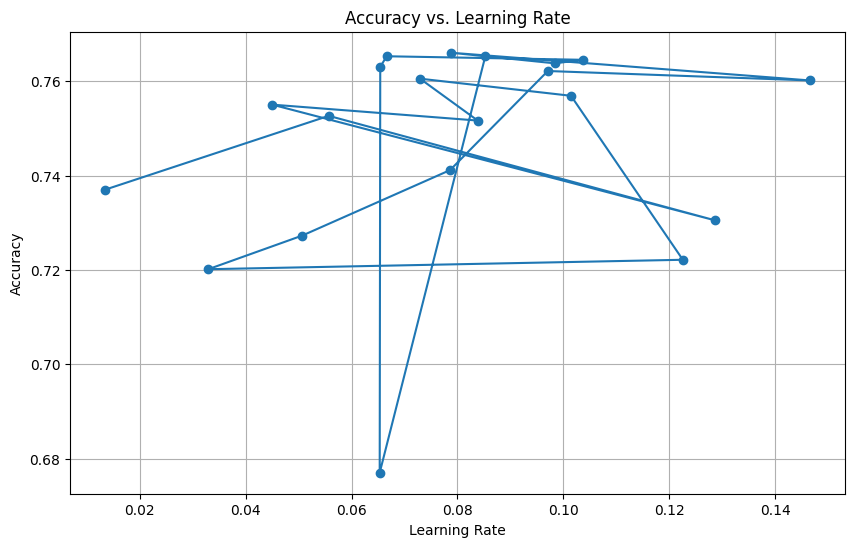

In [11]:
import matplotlib.pyplot as plt

# 提取学习率和准确率
learning_rates = [all_accuracies[key]['learning_rate'] for key in sorted(all_accuracies.keys())]
accuracies = [all_accuracies[key]['accuracy'] for key in sorted(all_accuracies.keys())]

plt.figure(figsize=(10, 6))
plt.plot(learning_rates, accuracies, marker='o', linestyle='-')
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Learning Rate')
plt.grid(True)
plt.show()


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


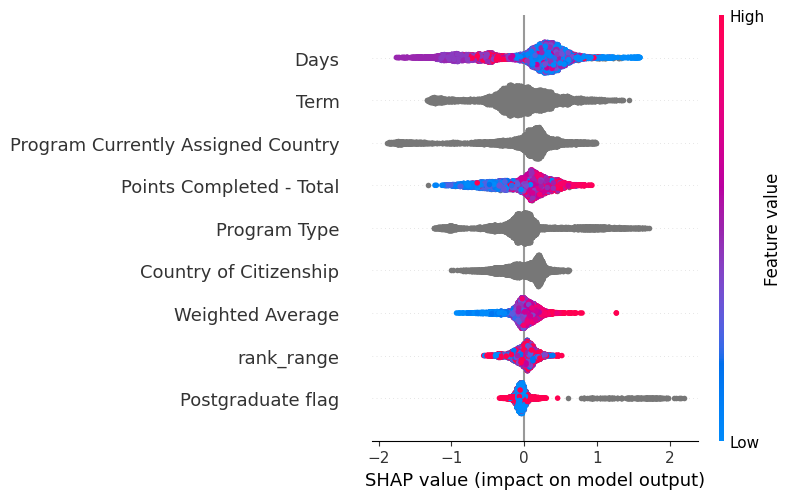

In [10]:
import shap

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(Pool(data=X_test, label=y_test, cat_features=cat_feature_indices))

plt.figure(figsize=(10, 6))

shap.summary_plot(shap_values, X_test, show=False)  # 设置show=False以防止立即显示图形

plt.savefig("shap_summary_plot.png", bbox_inches='tight', dpi=300)
plt.show()
plt.close()




In [8]:
from sklearn.metrics import classification_report

y_pred = final_model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.78      0.80      3973
           1       0.80      0.83      0.81      4021

    accuracy                           0.81      7994
   macro avg       0.81      0.81      0.81      7994
weighted avg       0.81      0.81      0.81      7994



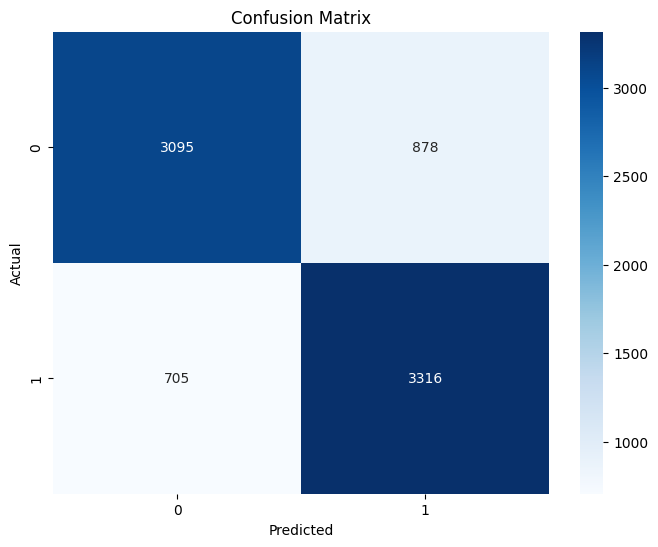

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')


plt.savefig("confusion_maxtrix.png",bbox_inches='tight', dpi=300)
plt.show()
plt.close()







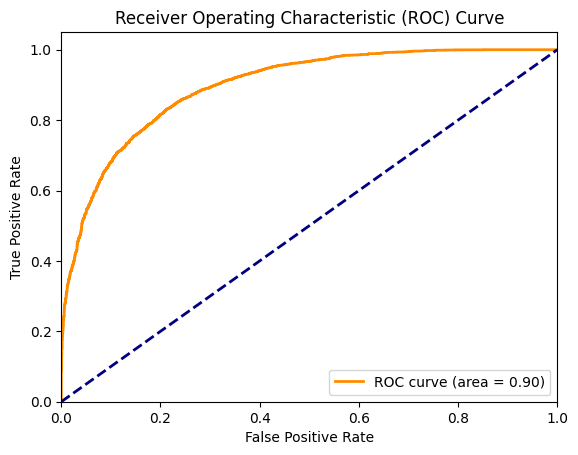

In [9]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# 获取模型的预测概率
y_pred_prob = final_model.predict_proba(X_test)[:,1]

# 计算ROC曲线
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# 计算AUC
roc_auc = auc(fpr, tpr)

# 绘制ROC曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.savefig("roc_auc.png",bbox_inches='tight', dpi=300)
plt.show()
# 关闭图形
plt.close()



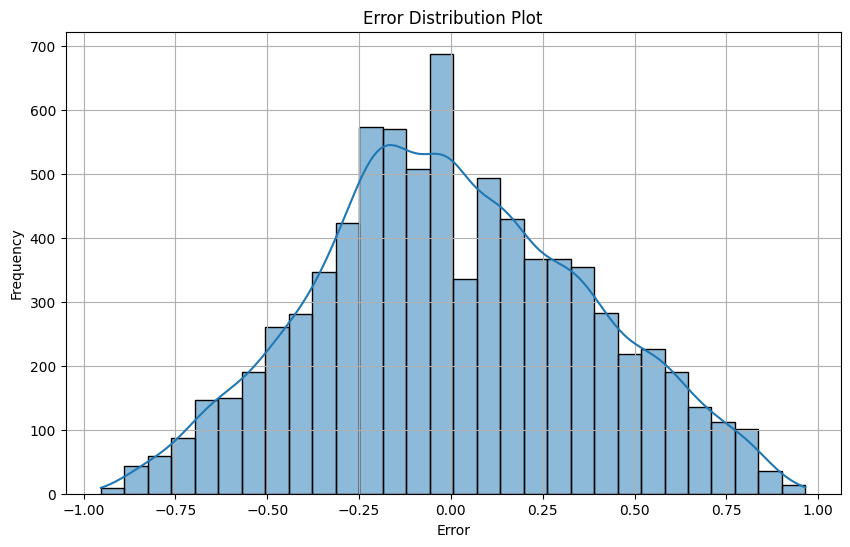

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_prob = final_model.predict_proba(X_test)[:,1]


errors = y_pred_prob - y_test


plt.figure(figsize=(10, 6))
sns.histplot(errors, kde=True, bins=30)
plt.title('Error Distribution Plot')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig("residual.png",bbox_inches='tight', dpi=300)
plt.show()

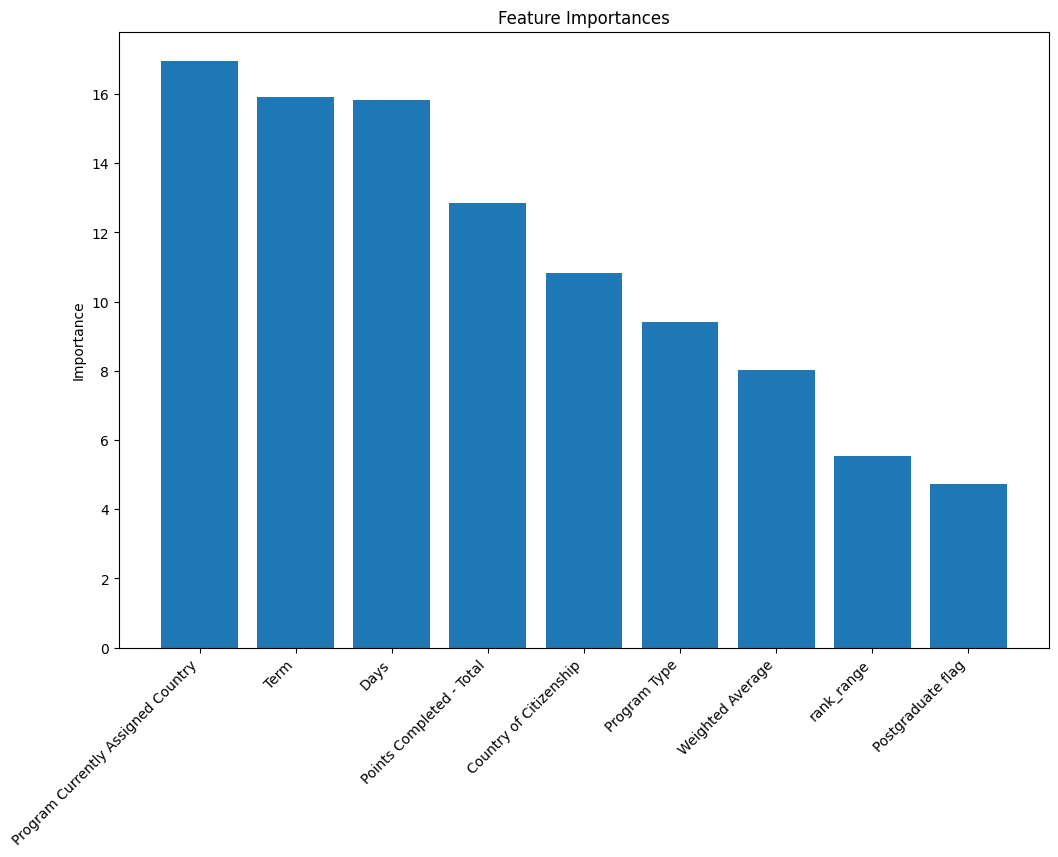

In [27]:
import matplotlib.pyplot as plt


feature_importances = loaded_model.get_feature_importance()


feature_names = new_X.columns
importance_df = pd.DataFrame({
    'Features': feature_names,
    'Importance': feature_importances
})


importance_df = importance_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(12, 8))
plt.title("Feature Importances")
plt.bar(importance_df['Features'], importance_df['Importance'])
plt.xticks(rotation=45, ha='right')
plt.ylabel('Importance')
plt.savefig("feature.png",bbox_inches='tight', dpi=300)
plt.show()

In [7]:
final_model = CatBoostClassifier()
final_model.load_model('catboost.model')

In [24]:

Term = input("Enter Term: ")
Program_Country = input("Enter Program Currently Assigned Country: ")
Program_Type = input("Enter Program Type: ")
Citizenship = input("Enter Country of Citizenship: ")
Points_Completed = float(input("Enter Points Completed - Total: "))
Weighted_Average = float(input("Enter Weighted Average: "))
Postgraduate_flag = int(input("Enter Postgraduate flag (0 or 1): "))
Days = int(input("Enter Days: "))
rank_range = input("Enter rank range: ")


data = {
    'Term': [Term],
    'Program Currently Assigned Country': [Program_Country],
    'Program Type': [Program_Type],
    'Country of Citizenship': [Citizenship],
    'Points Completed - Total': [Points_Completed],
    'Weighted Average': [Weighted_Average],
    'Postgraduate flag': [Postgraduate_flag],
    'Days': [Days],
    'rank_range': [rank_range]
}

new_X = pd.DataFrame(data)


Enter Term:  Winter
Enter Program Currently Assigned Country:  Australia
Enter Program Type:  unknow
Enter Country of Citizenship:  China
Enter Points Completed - Total:  0
Enter Weighted Average:  90
Enter Postgraduate flag (0 or 1):  0
Enter Days:  130
Enter rank range:  4


In [26]:
predicted_probabilities = loaded_model.predict_proba(new_X)
suss = predicted_probabilities[:,0]
nonsuss = predicted_probabilities[:,1]

print('To success apply the program is',suss)
print('To fail apply the program is',nonsuss)

To success apply the program is [0.13398896]
To fail apply the program is [0.86601104]


,Term,Program Currently Assigned Country,Program Type,Country of Citizenship,Points Completed - Total,Weighted Average,Postgraduate flag,Days,rank_range
0,Winter,Australia,unknow,China,0.0,90.0,0,130,4


## DNN

In [22]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data[:,1:]
y = to_categorical(data[:,0])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)


model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model = Sequential()
model.add(Dense(64, activation='relu'))
model = Sequential()
model.add(Dense(2, activation='softmax')) 


model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_test, y_test))




Epoch 1/100
484/484 [==============================] - 2s 2ms/step - loss: 0.6506 - accuracy: 0.6064 - val_loss: 0.6416 - val_accuracy: 0.6159
Epoch 2/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6401 - accuracy: 0.6155 - val_loss: 0.6434 - val_accuracy: 0.6050
Epoch 3/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6392 - accuracy: 0.6194 - val_loss: 0.6393 - val_accuracy: 0.6208
Epoch 4/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6383 - accuracy: 0.6182 - val_loss: 0.6419 - val_accuracy: 0.6115
Epoch 5/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6390 - accuracy: 0.6165 - val_loss: 0.6439 - val_accuracy: 0.6168
Epoch 6/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6385 - accuracy: 0.6187 - val_loss: 0.6402 - val_accuracy: 0.6251
Epoch 7/100
484/484 [==============================] - 1s 2ms/step - loss: 0.6381 - accuracy: 0.6160 - val_loss: 0.6406 - val_accuracy: 0.6141

## MLP

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 定义MLP模型
def create_mlp(input_dim, num_classes):
    model = Sequential()

    # 输入层和第一个隐藏层
    model.add(Dense(128, input_dim=input_dim, activation='relu'))

    # 第二个隐藏层
    model.add(Dense(64, activation='relu'))

    # 输出层
    if num_classes == 2:
        # 二分类
        model.add(Dense(1, activation='sigmoid'))
        model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    else:
        # 多分类
        model.add(Dense(num_classes, activation='softmax'))
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

# 假设输入特征维度为10，要解决的是一个三分类问题
input_dim = 10
num_classes = 3

model = create_mlp(input_dim, num_classes)
model.summary()
